In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import src.tomo_fusion.hyperparameter_tuning as hyper
import src.tomo_fusion.functionals_definition as fct_def
import numpy as np
import copy
import matplotlib.pyplot as plt
import skimage.transform as skimt
import src.tomo_fusion.bayesian_computations as bcomp
import src.tomo_fusion.tools.helpers as tomo_helps
import time

In [10]:
# Load phantom data
psis = np.load('../../../dataset_generation/sxr_samples/psis.npy')
sxr_samples  = np.load('../../../dataset_generation/sxr_samples/sxr_samples_with_background.npy')
alphas  = np.load('../../../dataset_generation/sxr_samples/alpha_random_values.npy')
trim_vals = np.load('../../../dataset_generation/sxr_samples/trimming_values.npy')
random_peak_vals  = np.load('../../../dataset_generation/sxr_samples/peak_values_gaussian_background.npy')


In [11]:
reg_param_data, best_reg_param, nb_occurrences, factors_avg_wrt_best, factors_median_wrt_best, reg_param_median = [],[],[],[],[],[]

anis_param_data, factors_cv_wrt_best_random, factors_cv_wrt_best_random_full, mse_cv_random_full, mse_avg_alpha, factors_cv_wrt_best_camera, factors_cv_wrt_best_camera_full = [],[],[],[],[],[], []

In [12]:
sigmas = ["sigma005", "sigma01", "sigma005005"]

for sigma in sigmas:

    reg_param_data.append(np.load('tuning_data/reg_param_tuning_'+sigma+'/tuning_data.npy', allow_pickle=True))
    best_reg_param.append(np.load('tuning_data/reg_param_tuning_'+sigma+'/best_hyperparams.npy'))
    nb_occurrences.append(np.load('tuning_data/reg_param_tuning_'+sigma+'/nb_occurrences.npy'))
    factors_avg_wrt_best.append(np.load('tuning_data/reg_param_tuning_'+sigma+'/factors_avg_wrt_best.npy'))
    factors_median_wrt_best.append(np.load('tuning_data/reg_param_tuning_'+sigma+'/factors_median_wrt_best.npy'))
    reg_param_median.append(np.load('tuning_data/reg_param_tuning_'+sigma+'/reg_param_median.npy'))
    
    anis_param_data.append(np.load('tuning_data/anis_param_tuning_'+sigma+'/tuning_data.npy', allow_pickle=True))
    factors_cv_wrt_best_random.append(np.load('tuning_data/anis_param_tuning_'+sigma+'/factors_cv_wrt_best_random.npy'))
    factors_cv_wrt_best_random_full.append(np.load('tuning_data/anis_param_tuning_'+sigma+'/factors_cv_wrt_best_random_full.npy'))
    mse_cv_random_full.append(np.load('tuning_data/anis_param_tuning_'+sigma+'/mse_cv_random_full.npy'))
    mse_avg_alpha.append(np.load('tuning_data/anis_param_tuning_'+sigma+'/mse_average_alpha.npy'))
    factors_cv_wrt_best_camera.append(np.load('tuning_data/anis_param_tuning_'+sigma+'/factors_cv_wrt_best_camera.npy'))
    factors_cv_wrt_best_camera_full.append(np.load('tuning_data/anis_param_tuning_'+sigma+'/factors_cv_wrt_best_camera_full.npy'))

In [ ]:
# recompute maps to generate new data for comparison table

mses_map = np.zeros((3, 100, 3))
mses_map_core = np.zeros((3, 100, 3))

sigmas_stats = ["sigma005", "sigma01", "sigma005005"]

sigma_errs = []
sigma_errs.append(np.load('tuning_data/reg_param_tuning_sigma005/sigma_err.npy'))
sigma_errs.append(np.load('tuning_data/reg_param_tuning_sigma01/sigma_err.npy'))
sigma_errs.append(np.load('tuning_data/reg_param_tuning_sigma005005/sigma_err.npy'))

reg_param_medians = np.array([np.load('tuning_data/reg_param_tuning_sigma005/reg_param_median.npy'),
                              np.load('tuning_data/reg_param_tuning_sigma01/reg_param_median.npy'),
                              0.1])

map_times = np.zeros((3,100))

for sigma_idx, sigma in enumerate(sigmas_stats):
    sigma_err = sigma_errs[sigma_idx]
    estimated_alphas = np.load('tuning_data/anis_param_tuning_'+sigma+'/best_hyperparams.npy', allow_pickle=True)[:, 2]
    true_alphas = alphas[900:]
    average_alphas = 1e-2 * np.ones(100)
    
    for i, idx in enumerate(np.arange(900, 1000)):
        print("Processing error level ", sigma, ", phantom ", idx)
        
        ground_truth = copy.deepcopy(sxr_samples[idx, :, :].squeeze())
        psi = psis[idx, :, :]
        alpha = alphas[idx]
        trim_val_ = trim_vals[idx, :]
        mask_core = tomo_helps.define_core_mask(psi=psi, dim_shape=(120,40), trim_values_x=trim_val_)
    
        # anisotropic regularization functional
        reg_fct_type = "anisotropic"
        
        # compute MAP with reg_param=median, CV-estimate alpha
        f, g = fct_def.define_loglikelihood_and_logprior(ground_truth=ground_truth, psi=psi,
                                                         sigma_err=sigma_err, reg_fct_type=reg_fct_type,
                                                         alpha=estimated_alphas[i], plot=False,
                                                         seed=idx)
        time_init = time.time()
        map_estimated_alpha = bcomp.compute_MAP(f, g, reg_param_medians[sigma_idx], with_pos_constraint=True, clipping_mask=mask_core, show_progress=False)
        map_times[sigma_idx, i] = time.time() - time_init
    
        # compute MAP with reg_param=median, average alpha=1e-2
        g = hyper._redefine_anis_param_logprior(g, alpha_new=1e-2)
        # compute MSE
        map_average_alpha = bcomp.compute_MAP(f, g, reg_param_medians[sigma_idx], with_pos_constraint=True, clipping_mask=mask_core, show_progress=False)
        
        # compute MAP with reg_param=best, true alpha
        mse_argmin = np.argmin(reg_param_data[sigma_idx][i]['GT'][2, :])
        best_reg_param_idx = reg_param_data[sigma_idx][i]['GT'][0, mse_argmin]
        g = hyper._redefine_anis_param_logprior(g, alpha_new=alpha)
        # compute MSE
        map_best = bcomp.compute_MAP(f, g, best_reg_param_idx, with_pos_constraint=True, clipping_mask=mask_core, show_progress=False)
        
        # compute stats for the 3 different MAPs
        downsampled_phantom =  skimt.resize(ground_truth, f.dim_shape[1:], anti_aliasing=False, mode='edge')
        mses_map[sigma_idx, i, 0] = np.mean((map_estimated_alpha - downsampled_phantom) ** 2)
        mses_map[sigma_idx, i, 1] = np.mean((map_average_alpha - downsampled_phantom) ** 2)
        mses_map[sigma_idx, i, 2] = np.mean((map_best - downsampled_phantom) ** 2)
        mses_map_core[sigma_idx, i, 0] = np.mean((map_estimated_alpha[mask_core] - downsampled_phantom[mask_core]) ** 2)
        mses_map_core[sigma_idx, i, 1] = np.mean((map_average_alpha[mask_core] - downsampled_phantom[mask_core]) ** 2)
        mses_map_core[sigma_idx, i, 2] = np.mean((map_best[mask_core] - downsampled_phantom[mask_core]) ** 2)
    

In [18]:
sigmas = ["sigma 5%: moderate noise regime", "sigma 10%: high noise regime", "sigma 5% + 5% of measurement: signal-dependent noise"]

rel_errs, rel_err_cores = np.zeros((4, 100, 2)), np.zeros((4, 100, 2))

for j in range(3):
    print(sigmas[j])
    
    rmses_map = np.sqrt(mses_map)
    rmses_map_core = np.sqrt(mses_map_core)
 
    print("RMSE average CV random full ", np.mean(rmses_map[j, :, 0]), "+-", np.std(rmses_map[j, :, 0]))   
    print("RMSE average fixed alpha ", np.mean(rmses_map[j, :, 1]), "+-", np.std(rmses_map[j, :, 1]))
    print("RMSE average best true alpha ", np.mean(rmses_map[j, :, 2]), "+-", np.std(rmses_map[j, :, 2]))
    print("RMSE core average CV random full ", np.mean(rmses_map_core[j, :, 0]), "+-", np.std(rmses_map_core[j, :, 0]))   
    print("RMSE core average fixed alpha ", np.mean(rmses_map_core[j, :, 1]), "+-", np.std(rmses_map_core[j, :, 1]))
    print("RMSE core average best true alpha ", np.mean(rmses_map_core[j, :, 2]), "+-", np.std(rmses_map_core[j, :, 2]))
    

    rel_err = 100*(rmses_map[j, :, 0]-rmses_map[j, :, 2])/rmses_map[j, :, 2]
    rel_err_avg_alpha = 100*(rmses_map[j, :, 1]-rmses_map[j, :, 2])/rmses_map[j, :, 2]
    rel_err_core = 100*(rmses_map_core[j, :, 0]-rmses_map_core[j, :, 2])/rmses_map_core[j, :, 2]
    rel_err_avg_alpha_core = 100*(rmses_map_core[j, :, 1]-rmses_map_core[j, :, 2])/rmses_map_core[j, :, 2]

    print("CV-alpha")
    print("Average relative error on best RMSE ",np.mean(rel_err), "+-", np.std(rel_err))
    print("Median relative error on best RMSE", np.median(rel_err))
    print("90% quantile  relative error on best RMSE", np.quantile(rel_err, 0.9))
    print("Fixed alpha")
    print("Average relative error on best RMSE ",np.mean(rel_err_avg_alpha), "+-", np.std(rel_err_avg_alpha))
    print("Median relative error on best RMSE", np.median(rel_err_avg_alpha))
    print("90% quantile  relative error on best RMSE", np.quantile(rel_err_avg_alpha, 0.9))
    
    print("CV-alpha, core")
    print("Average relative error on best RMSE ",np.mean(rel_err_core), "+-", np.std(rel_err_core))
    print("Median relative error on best RMSE", np.median(rel_err_core))
    print("90% quantile  relative error on best RMSE", np.quantile(rel_err_core, 0.9))
    print("Fixed alpha, core")
    print("Average relative error on best RMSE ",np.mean(rel_err_avg_alpha_core), "+-", np.std(rel_err_avg_alpha_core))
    print("Median relative error on best RMSE", np.median(rel_err_avg_alpha_core))
    print("90% quantile  relative error on best RMSE", np.quantile(rel_err_avg_alpha_core, 0.9))
    
    print("\n\n")
    
    rel_errs[j, :, 0] = rel_err
    rel_errs[j, :, 1] = rel_err_avg_alpha
    rel_err_cores[j, :, 0] = rel_err_core
    rel_err_cores[j, :, 1] = rel_err_avg_alpha_core



sigma 5%: moderate noise regime
RMSE average CV random full  0.01990384790081467 +- 0.0069431280328360635
RMSE average fixed alpha  0.020246813576034115 +- 0.006435335402763167
RMSE average best true alpha  0.018852256453937604 +- 0.00694830517313475
RMSE core average CV random full  0.0327662361224829 +- 0.011422257696120949
RMSE core average fixed alpha  0.033355100497085434 +- 0.01052021473945734
RMSE core average best true alpha  0.030991046237674208 +- 0.011425986648504102
CV-alpha
Average relative error on best RMSE  6.8459017448256825 +- 15.617819769032607
Median relative error on best RMSE 4.017865268424801
90% quantile  relative error on best RMSE 19.70704273557976
Fixed alpha
Average relative error on best RMSE  9.874234991236621 +- 12.66151002834812
Median relative error on best RMSE 8.117232144994947
90% quantile  relative error on best RMSE 24.477551433206138
CV-alpha, core
Average relative error on best RMSE  6.987837143661686 +- 15.928627905136949
Median relative error o

In [19]:
anis_param_tuning_stats = {"rmses_map": rmses_map, "rmses_map_core": rmses_map_core, "rel_errs": rel_errs, "rel_errs_core": rel_err_cores}
np.save('tuning_data/anis_param_tuning_summary_stats.npy', anis_param_tuning_stats)

<Figure size 640x480 with 0 Axes>

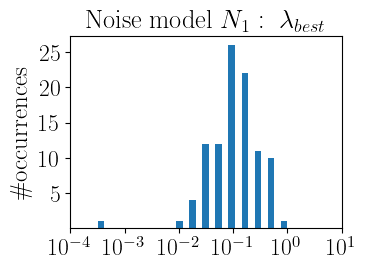

In [20]:
plt.figure()
vec = np.zeros(100)
counter=0
model=0
for i in range(reg_param_data[model][0]["GT"].shape[1]):
    nb_occurrences_i = np.where(best_reg_param[model] == reg_param_data[model][0]["GT"][0,i])[0].size
    vec[counter:counter+nb_occurrences_i] = i
    counter += nb_occurrences_i
plt.figure(figsize=(3.5,2.5))
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
})
plt.hist(vec, bins=29)
plt.xticks([0,4,8,12,16,20], [r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", r"$10^{0}$", r"$10^{1}$"], fontsize=17)
plt.yticks([5,10,15,20,25], fontsize=17)#, [r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", r"$10^{0}$", r"$10^{1}$"], fontsize=16)
plt.title(r"$\mathrm{Noise \;model \;}N_1:\;\lambda_{best}$", fontsize=19)
#plt.xlabel(r"$\lambda_{best}$", fontsize=17)
plt.ylabel(r"$\# \mathrm{occurrences}$", fontsize=18, labelpad=5)
#plt.ylabel(r"$\mathrm{occurrences}$", fontsize=17, labelpad=5)

#plt.savefig('../../../figures/reg_param_tuning.eps', format='eps', bbox_inches="tight")

plt.show()